# Predicting Detroit Blight Tickets


### _In this notebook, we work on a dateset of Blight Tickets issued by City Detroit. Here we explore various feature selection techniques, as well as comparing the performance of different machine learning algorithms. Conclusions are drawn at the end of this notebook_ 

 
Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided through the [Detroit Open Data Portal](https://data.detroitmi.gov/). 
* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

There are two data files for use in training and validating the models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
    state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant




## Load Data and perform Data Pre-processing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

df = pd.read_csv('train.csv', encoding = 'ISO-8859-1')
test = pd.read_csv('test.csv', encoding = 'ISO-8859-1')
address = pd.read_csv('addresses.csv', encoding = 'ISO-8859-1')
latlon =  pd.read_csv('latlons.csv', encoding = 'ISO-8859-1')
address_new = address.merge(latlon, on='address', how='inner')
df = df.merge(address_new, on='ticket_id', how='inner')
df = df.set_index('ticket_id')
df_test = test.merge(address_new, on='ticket_id', how='inner')
df_test = df_test.set_index('ticket_id')
df=df.dropna(subset=['compliance'])

df['date_diff'] = (pd.to_datetime(df['hearing_date']) - pd.to_datetime(df['ticket_issued_date'])).dt.days
df_test['date_diff'] = (pd.to_datetime(df_test['hearing_date']) - pd.to_datetime(df_test['ticket_issued_date'])).dt.days

keep_list=['agency_name', 'lat', 'lon', 'date_diff', 'violation_code', 
          'disposition', 'fine_amount', 'late_fee', 'discount_amount', 'compliance']
df_test['compliance']=0.0
df = df[keep_list]
df_test = df_test[keep_list]
df = df.dropna()

numeric_list = ['lat', 'lon', 'date_diff',  'fine_amount', 'late_fee', 'discount_amount']
non_numeric_list = ['agency_name', 'violation_code', 'disposition']
train_num = len(df)


df_all = pd.concat([df, df_test]) 
df_all = pd.get_dummies(df_all, columns=non_numeric_list) ## transform categorical features to numerical

df_train = df_all.iloc[:train_num,:]
df_test = df_all.iloc[train_num:, :]



/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Reasons for the keep list:

1) admin_fee, state_fee, there is almost no difference for each instance;

2) fine_amount and judgment_amount amount is highly correlated, correlation coeficient = 0.999



## Explorative Data Analysis


In [3]:
df_train['compliance'].value_counts()

0.0    148220
1.0     11431
Name: compliance, dtype: int64

We can tell that this dataset is **Imbalanced**

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns=['compliance']), df_train['compliance'], stratify = df_train['compliance'], random_state=10)



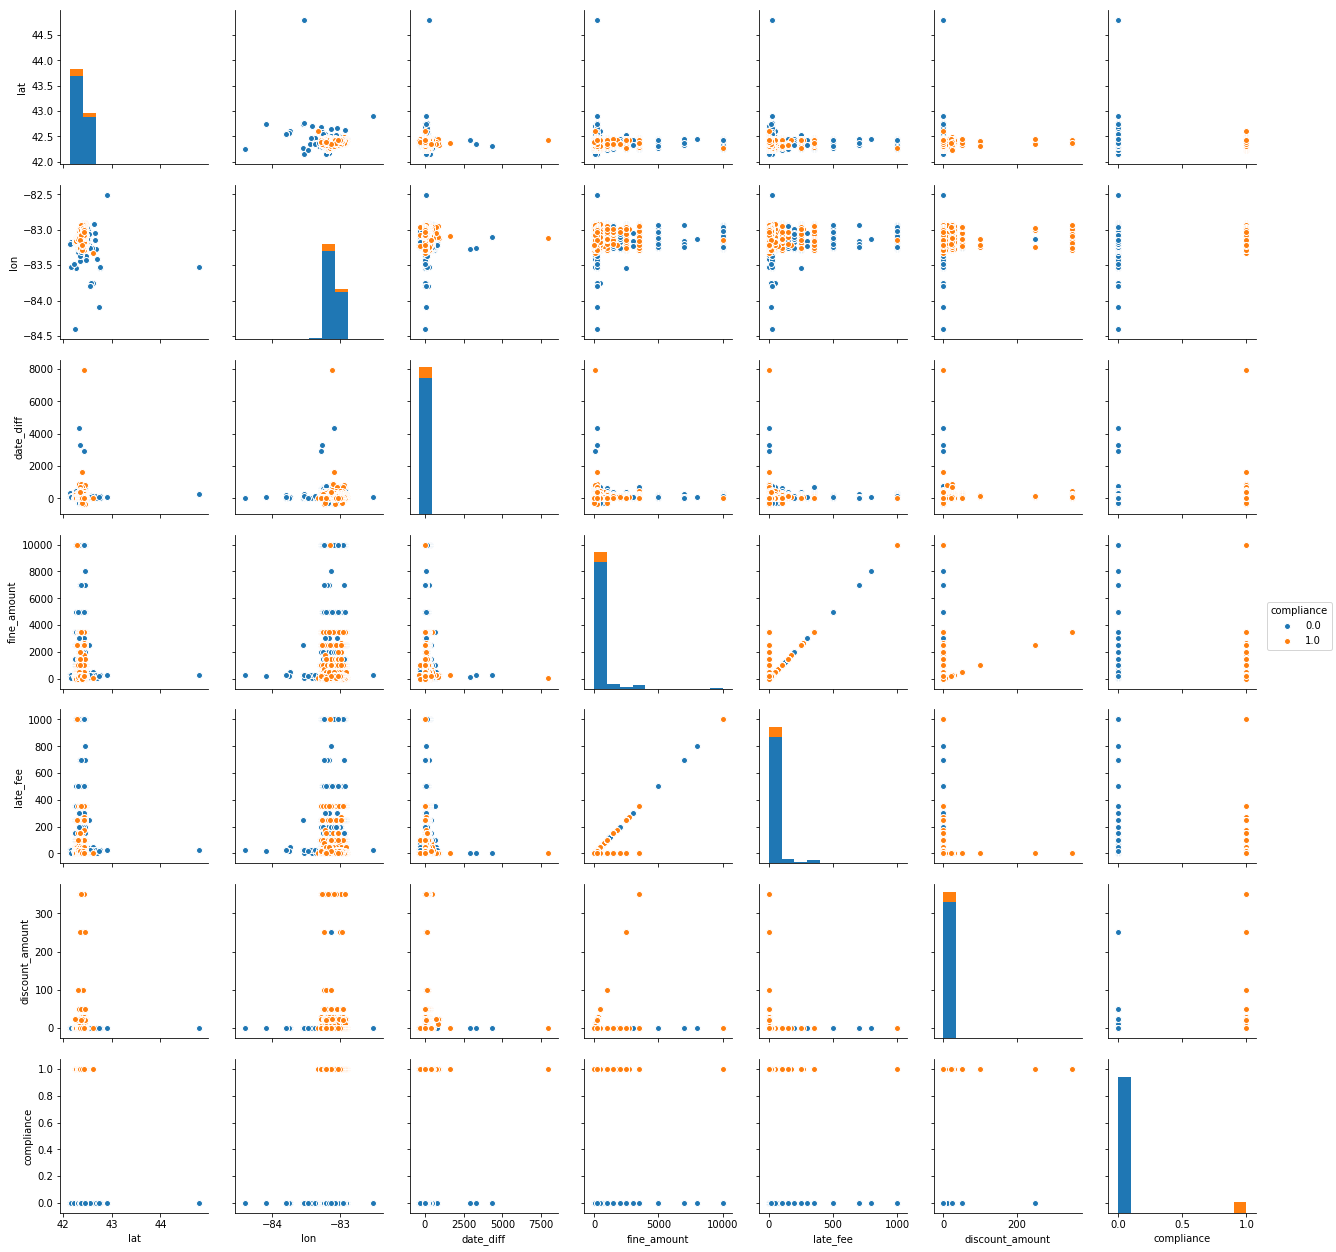

In [5]:
import seaborn as sns

sns.pairplot(df_train[numeric_list+['compliance']], hue ='compliance')

## Comparing different Feature selection Techniques

Here we explore each feature selection techniques and compare their results

1) Feature selection based on correlation (Preliminary)

2) Univariate feature selection (select K-best)

3) Random Forest

4) Lasso

5) Recursive feature selection



In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler().fit_transform(X_train)
X_train = X_train.applymap(lambda x: -1*x if x<0 else x)

select_feature = SelectKBest(chi2, k=20).fit(X_train, y_train)

In [16]:
mask = select_feature.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, X_train.columns):
    if bool:
        new_features.append(feature)
new_features


['date_diff',
 'fine_amount',
 'late_fee',
 'discount_amount',
 'agency_name_Buildings, Safety Engineering & Env Department',
 'agency_name_Department of Public Works',
 'agency_name_Detroit Police Department',
 'violation_code_19450901',
 'violation_code_22-2-43',
 'violation_code_22-2-45',
 'violation_code_22-2-61',
 'violation_code_61-81.0100/32.0066',
 'violation_code_9-1-103(C)',
 'violation_code_9-1-110(a)',
 'violation_code_9-1-43(a) - (Dwellin',
 'violation_code_9-1-81(a)',
 'disposition_Responsible (Fine Waived) by Deter',
 'disposition_Responsible by Admission',
 'disposition_Responsible by Default',
 'disposition_Responsible by Determination']

In [17]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
MinMaxScaler().fit_transform(X_train)

select_feature = SelectKBest(f_classif, k=20).fit(X_train, y_train)
mask = select_feature.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, X_train.columns):
    if bool:
        new_features.append(feature)
new_features



/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 11  17  19  33  35  39  40  43  52  56  57  61  69  71  75  78  80  81
  82  84  86  87  89  90  92  95 102 105 115 116 119 121 124 142 143 163
 173 178 182 192 197 205 207 208 214 234 236 237 241] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


['lat',
 'fine_amount',
 'late_fee',
 'discount_amount',
 'agency_name_Buildings, Safety Engineering & Env Department',
 'agency_name_Department of Public Works',
 'agency_name_Detroit Police Department',
 'violation_code_19450901',
 'violation_code_22-2-43',
 'violation_code_22-2-45',
 'violation_code_22-2-61',
 'violation_code_61-81.0100/32.0066',
 'violation_code_9-1-103(C)',
 'violation_code_9-1-110(a)',
 'violation_code_9-1-43(a) - (Dwellin',
 'violation_code_9-1-81(a)',
 'disposition_Responsible (Fine Waived) by Deter',
 'disposition_Responsible by Admission',
 'disposition_Responsible by Default',
 'disposition_Responsible by Determination']

The two statistics (chi2 vs. f_classif) show similar results for the first 15 best features, except that chi2 captures feature **'date_diff'** as important while f_classif misses it. On the other hand, f_classif captures feature **'lat'**, while chi2 does not

In [24]:
# Select From Model: SVC and Decision Trees

from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True)
feature_idx = model.get_support()
X_train.columns[feature_idx]


Index(['lat', 'lon', 'date_diff', 'fine_amount', 'late_fee', 'discount_amount',
       'agency_name_Department of Public Works',
       'agency_name_Detroit Police Department', 'violation_code_22-2-45',
       'violation_code_22-2-61', 'violation_code_9-1-103(C)',
       'violation_code_9-1-104', 'violation_code_9-1-36(a)',
       'violation_code_9-1-81(a)',
       'disposition_Responsible (Fine Waived) by Deter',
       'disposition_Responsible by Default',
       'disposition_Responsible by Determination'],
      dtype='object')

In [20]:
from sklearn.ensemble import RandomForestClassifier
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(X_train,y_train)
importances = clr_rf_5.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(20):
    print(f + 1, X_train.columns[indices[f]], importances[indices[f]])



Feature ranking:
1 lon 0.2722075754086581
2 lat 0.26980717759450684
3 date_diff 0.17444077849300196
4 late_fee 0.10346752051717496
5 discount_amount 0.04067354211169024
6 disposition_Responsible by Admission 0.03293356657777576
7 disposition_Responsible by Default 0.02891895469739541
8 disposition_Responsible by Determination 0.027151960730447365
9 fine_amount 0.01398429980327815
10 disposition_Responsible (Fine Waived) by Deter 0.0029100015845738977
11 agency_name_Department of Public Works 0.0023338597698672773
12 violation_code_9-1-81(a) 0.002230127350463338
13 agency_name_Buildings, Safety Engineering & Env Department 0.0017116424776197666
14 violation_code_22-2-88 0.0016359983279919763
15 violation_code_22-2-61 0.0016062469417152795
16 violation_code_9-1-103(C) 0.001518713732822557
17 violation_code_9-1-104 0.0014802645203304348
18 violation_code_22-2-22 0.0014634139830635542
19 violation_code_9-1-36(a) 0.001395468225892484
20 agency_name_Health Department 0.0013922562830187863


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=15, step=5)
rfe = rfe.fit(X_train, y_train)
X_train.columns[rfe.support_]

To Summarize: <br>
1) The Univariate featrue selection methods fail to capture the address features, **'lat'** and **'lon'**, due to the disability to capture the nonlinear relationship between the variable and the target. <br>
2) Feature Selected from model, with applying Lasso (leading to sparse matrix) and Tree-based feature importance. We found that they can capture the same important features. Overall, RFE gives relatively stable feature importance, and we will use the features selected by RFE.


## Comparing different machine learning algorithms

1) Regulated logistic regression (Ridge)

2) KNN

3) SVC, kernelized SVC

4) Random Forest, Gradient boosting trees

5) artificial neural network




In [6]:
# From the features selected by RFE, we form the final keep list of the features to train the model
keep_list=['lat', 'lon', 'date_diff', 'fine_amount', 'late_fee', 'discount_amount',
       'violation_code_9-1-36(a)', 'disposition_Responsible by Admission',
       'disposition_Responsible by Default',
       'disposition_Responsible by Determination','disposition_Responsible (Fine Waived) by Deter','agency_name_Department of Public Works',
           'agency_name_Buildings, Safety Engineering & Env Department',
       'agency_name_Detroit Police Department',
       'agency_name_Health Department', 'violation_code_22-2-45',
       'violation_code_22-2-61', 'violation_code_9-1-104',
           'compliance']
df_train = df_train[keep_list]

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns=['compliance']), df_train['compliance'], 
                                                    random_state=11, stratify=df_train['compliance'])
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



## Metric to choose: auc, f1_score, accuracy, Confusion_Matrix
For an imbalanced dataset

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, f1_score

for this_c in [0.01, 0.1, 0.5, 1, 10, 100, 1000]:
    clf = LogisticRegression(penalty='l2', C=this_c, class_weight='balanced').fit(X_train, y_train)
    fpr_lr, tpr_lr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    print('this_c {}, Accuracy is {:.3f}, AUC score {:.3f}, f1score {:.3f}'.format(this_c, clf.score(X_test, y_test), 
                                                                               roc_auc_lr, f1_score(y_test, clf.predict(X_test))))
    print(confusion_matrix(y_test,clf.predict(X_test)))
   


this_c 0.01, Accuracy is 0.865, AUC score 0.798, f1score 0.386
[[32838  4217]
 [ 1165  1693]]
this_c 0.1, Accuracy is 0.861, AUC score 0.797, f1score 0.382
[[32674  4381]
 [ 1150  1708]]
this_c 0.5, Accuracy is 0.861, AUC score 0.797, f1score 0.380
[[32639  4416]
 [ 1150  1708]]
this_c 1, Accuracy is 0.861, AUC score 0.797, f1score 0.381
[[32657  4398]
 [ 1153  1705]]
this_c 10, Accuracy is 0.861, AUC score 0.797, f1score 0.380
[[32651  4404]
 [ 1155  1703]]
this_c 100, Accuracy is 0.861, AUC score 0.797, f1score 0.380
[[32651  4404]
 [ 1155  1703]]
this_c 1000, Accuracy is 0.861, AUC score 0.797, f1score 0.380
[[32651  4404]
 [ 1155  1703]]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, f1_score

for k in range(1,10):
    clf = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    fpr_lr, tpr_lr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    print('k= {}, Accuracy is: {:.3f}, AUC score: {:.3f}, f1score: {:.3f}'.format(k, clf.score(X_test, y_test), 
                                                                               roc_auc_lr, f1_score(y_test, clf.predict(X_test))))
    print(confusion_matrix(y_test,clf.predict(X_test)))

k 1, Accuracy is 0.909, AUC score 0.651, f1score 0.355
[[35303  1752]
 [ 1862   996]]
k 2, Accuracy is 0.938, AUC score 0.684, f1score 0.344
[[36789   266]
 [ 2210   648]]
k 3, Accuracy is 0.934, AUC score 0.699, f1score 0.391
[[36430   625]
 [ 2011   847]]


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, f1_score

for kernel in ['rbf', 'poly', 'linear']:
    for gamma in [0.01, 0.1, 1, 5]:
        clf = SVC(kernel=kernel, gamma=gamma, class_weight='balanced').fit(X_train, y_train)
        fpr_lr, tpr_lr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
        roc_auc_lr = auc(fpr_lr, tpr_lr)
        print('kernal {}, gamma {}, Accuracy is {:.3f}, AUC score {:.3f}, f1score {:.3f}'.format(kernel, gamma, clf.score(X_test, y_test), 
                                                                               roc_auc_lr, f1_score(y_test, clf.predict(X_test))))
    print(confusion_matrix(y_test,clf.predict(X_test)))
   

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, f1_score


for max_features in range(1,10):
    clf = RandomForestClassifier(max_features = max_features, random_state = 0, class_weight='balanced').fit(X_train, y_train)
    fpr_lr, tpr_lr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    print('max_features {}, score is {:.3f}, AUC score {:.3f}, f1score {:.3f}'.format(max_features,clf.score(X_test, y_test), 
                                                                               roc_auc_lr, f1_score(y_test, clf.predict(X_test))))
    print(confusion_matrix(y_test,clf.predict(X_test)))
   

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, f1_score

for alpha in [0.2, 0.3]:
    for max_depth in [2, 3, 4, 5, 6,7]:
        clf = GradientBoostingClassifier(learning_rate = alpha, max_depth = max_depth, random_state = 0).fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        fpr_lr, tpr_lr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
        roc_auc_lr = auc(fpr_lr, tpr_lr)
        print('learning_rate {}, max_depth {}, score is {:.3f}, AUC score {:.3f}, f1score {:.3f}'.format(alpha, max_depth,clf.score(X_test, y_test), 
                                                                               roc_auc_lr, f1_score(y_test, y_pred)))
        print(confusion_matrix(y_test,y_pred))

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, f1_score

this_activation = 'tanh'
for this_alpha in [0.01, 0.1, 0.5]:
        clf = MLPClassifier(solver='lbfgs', activation = this_activation,
                         alpha = this_alpha, hidden_layer_sizes = [20,10 ],
                         random_state = 0, class_weight='balanced').fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
            
        print('With alapha {} , f1_score is {:.4f}, score is {:.4f}, auc is {:.4f}'.format(this_alpha,
                                                                                           f1_score(y_test,y_pred),
                                                                                          clf.score(X_test, y_test),
                                                                                          auc(fpr,tpr)))

## Choosing Random Forest and apply GridSearchCV


# Conclusion